# Book 5c - Gradient Boost 10k data set

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import random
import datetime
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patheffects as path_effects
from matplotlib import cm as cm2
matplotlib.style.use('ggplot') 
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn import linear_model, datasets
from sklearn.grid_search import GridSearchCV
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, \
    GradientBoostingClassifier, ExtraTreesClassifier, BaggingRegressor, \
    ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score \
#     confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score
from sklearn.cross_validation import train_test_split, KFold, cross_val_score


matplotlib.style.use('ggplot') 
sns.set_style("darkgrid")
%matplotlib inline

/Users/alex/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/alex/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Bring in X & T train & test

In [2]:
# data = pd.read_csv('./data/data_bk1_complete.csv')
with open('./data/data_bk1_complete.pkl', 'r') as picklefile:
    data = pickle.load(picklefile)

In [3]:
# Use this to do train/test split after fit
display_list = list(data['display_id'].unique())

import random

# Random list from event_id list of df1 & df2
random.seed(a=44)
rand_list = random.sample(display_list,11000)

# these lists are for later splitting of train/test
train_list = rand_list[:10000]
test_list = rand_list[10000:]


In [4]:
# skinny down data to just what is needed before doing the fit
data = data[data['display_id'].isin(rand_list)]

In [5]:
data.tail(3)

,display_id,ad_id,clicked,uuid,document_id,platform,geo_location,country,state,DMA,date_local,period,day_of_mnth,hour,ads_per_page,ad_document_id,campaign_id,advertiser_id,doc_id_topic,ad_id_topic
77223,16874384,160764,0,a618ff8b112574,2673511,2,US>NJ>501,US,NJ,501,2016-06-26 23:59:45.144,overnight,26,23,4,1144499,18226,2553,275.0,260.0
77224,16874384,177111,0,a618ff8b112574,2673511,2,US>NJ>501,US,NJ,501,2016-06-26 23:59:45.144,overnight,26,23,4,1447390,21573,210,275.0,168.0
77225,16874384,262434,0,a618ff8b112574,2673511,2,US>NJ>501,US,NJ,501,2016-06-26 23:59:45.144,overnight,26,23,4,1621715,26260,2151,275.0,296.0


In [6]:
ad_count = data[['display_id', 'ads_per_page']]

In [7]:
ad_count.head()

,display_id,ads_per_page
0,1525,9
1,1525,9
2,1525,9
3,1525,9
4,1525,9


## Workaround for classifier data fit
If modeling on a larger scale, the data fit would include all states and all document pairs.

The scope of this woudl likely overload the local machine, so as a work around the data will be fit with only the combinations that are in the full data set.

For parameters that are not in the training set, they will have no impact on the classifier as they will all be zeros.

In [8]:
len(data)

56533

In [9]:
Y = data['clicked']
Y.head(2)

0    0
1    0
Name: clicked, dtype: int64

In [10]:
data.columns

Index([u'display_id', u'ad_id', u'clicked', u'uuid', u'document_id',
       u'platform', u'geo_location', u'country', u'state', u'DMA',
       u'date_local', u'period', u'day_of_mnth', u'hour', u'ads_per_page',
       u'ad_document_id', u'campaign_id', u'advertiser_id', u'doc_id_topic',
       u'ad_id_topic'],
      dtype='object')

In [11]:
disp_ID = data[['display_id','ad_id','clicked','ads_per_page']]

In [12]:
disp_ID.head(2)

,display_id,ad_id,clicked,ads_per_page
0,1525,8846,0,9
1,1525,45180,0,9


In [13]:
X = data[['display_id','platform', 'state', 'period', 'day_of_mnth', 'ads_per_page',
            'campaign_id', 'advertiser_id', 'doc_id_topic','ad_id_topic']]

In [14]:
# change numbers to strings before get_dummies

to_num_str = ['platform', 'day_of_mnth', 'ads_per_page', 'campaign_id', 
              'advertiser_id', 'doc_id_topic','ad_id_topic']

for s in to_num_str:
    print(s)
    X[s] = X[s].apply(str)

platform
day_of_mnth
ads_per_page
campaign_id
advertiser_id
doc_id_topic
ad_id_topic


/Users/alex/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# +++++++++++++++++++++++++++++++++++++++

In [15]:
start = datetime.datetime.now()

X = pd.get_dummies(X, prefix=['platform', 'state', 'period', 'day_of_mnth', 'ads_per_page',
            'campaign_id', 'advertiser_id', 'doc_id_topic','ad_id_topic'])


finish = datetime.datetime.now()
print(finish - start)

0:00:13.417112


In [16]:
X.head(1)

,display_id,platform_1,platform_2,platform_3,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,...,ad_id_topic_91.0,ad_id_topic_92.0,ad_id_topic_93.0,ad_id_topic_94.0,ad_id_topic_95.0,ad_id_topic_96.0,ad_id_topic_97.0,ad_id_topic_98.0,ad_id_topic_99.0,ad_id_topic_nan
0,1525,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
X = X.drop(['platform_3','state_AK','period_morning','campaign_id_18226','advertiser_id_2553',
       'doc_id_topic_275.0','ad_id_topic_91.0','ads_per_page_12','day_of_mnth_26'],1)

In [18]:
X.head(2)

,display_id,platform_1,platform_2,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,...,ad_id_topic_90.0,ad_id_topic_92.0,ad_id_topic_93.0,ad_id_topic_94.0,ad_id_topic_95.0,ad_id_topic_96.0,ad_id_topic_97.0,ad_id_topic_98.0,ad_id_topic_99.0,ad_id_topic_nan
0,1525,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1525,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
X_train = X[X['display_id'].isin(train_list)]
X_test = X[X['display_id'].isin(test_list)]

In [20]:
# remove display id from X_train and X_test
X_train.drop('display_id', axis=1, level=None, inplace=True, errors='raise')

/Users/alex/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [21]:
X_test.drop('display_id', axis=1, level=None, inplace=True, errors='raise')

/Users/alex/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [22]:
X_test.shape

(5193, 10067)

In [23]:
Y_train = list(disp_ID[disp_ID['display_id'].isin(train_list)]['clicked'])

In [24]:
Y_test = list(disp_ID[disp_ID['display_id'].isin(test_list)]['clicked'])

In [25]:
disp_ID_train = disp_ID[disp_ID['display_id'].isin(train_list)]
disp_ID_test = disp_ID[disp_ID['display_id'].isin(test_list)]

In [26]:
print('X_train length: {0:,}'.format(len(X_train)))
print('X_test  length:  {0:,}'.format(len(X_test)))

X_train length: 51,340
X_test  length:  5,193


In [27]:
print('Y_train length: {0:,}'.format(len(Y_train)))
print('Y_test  length:  {0:,}'.format(len(Y_test)))

Y_train length: 51,340
Y_test  length:  5,193


In [28]:
print('disp_ID_train length: {0:,}'.format(len(disp_ID_train)))
print('disp_ID_test  length:  {0:,}'.format(len(disp_ID_test)))

disp_ID_train length: 51,340
disp_ID_test  length:  5,193


# Gradient Boost

Gradient Boost default settings
* correct predictions: 314 
* Precent correct: 31.4%

Gradient Boost (learning rate = 0.1, n_estimators = 500 - precision gridsearch)
* correct predictions: 363
* Precent correct: 36.3%



In [29]:
start = datetime.datetime.now()

gbc = GradientBoostingClassifier( learning_rate = 0.1, n_estimators = 2000)

gbc.fit(X_train,Y_train)

finish = datetime.datetime.now()
print(finish - start)

2:45:19.423845


In [30]:
# get probabilities of clicked/not clicked
gbc_proba = gbc.predict_proba(X_test)
gbc_Y_proba = pd.DataFrame(gbc_proba,columns = ['p_no_click','p_click'])

In [31]:
X_test.head()

,platform_1,platform_2,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,...,ad_id_topic_90.0,ad_id_topic_92.0,ad_id_topic_93.0,ad_id_topic_94.0,ad_id_topic_95.0,ad_id_topic_96.0,ad_id_topic_97.0,ad_id_topic_98.0,ad_id_topic_99.0,ad_id_topic_nan
71,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
Disp_test = list(disp_ID_test['display_id'])
ads_pp_test = list(disp_ID_test['ads_per_page'])
len(Disp_test)

5193

In [33]:
ppp = gbc_Y_proba
# post processing of predictor

In [34]:
len(ppp)

5193

In [35]:
ppp['display_id'] = Disp_test

In [36]:
ppp.head()

,p_no_click,p_click,display_id
0,0.803400,0.196600,19234
1,0.906453,0.093547,19234
2,0.883601,0.116399,19234
3,0.827590,0.172410,19234
4,0.866905,0.133095,19234


In [37]:
disp_ID_test.head()

,display_id,ad_id,clicked,ads_per_page
71,19234,89726,0,6
72,19234,173384,0,6
73,19234,173400,1,6
74,19234,180960,0,6
75,19234,225440,0,6


## Reduce to 1-click per display id

In [38]:
checker = ppp
checker.head(3)

,p_no_click,p_click,display_id
0,0.803400,0.196600,19234
1,0.906453,0.093547,19234
2,0.883601,0.116399,19234


In [39]:
checker['Y_test'] = pd.Series(Y_test)
checker['prediction'] = [0 for _ in range(len(checker))] # puts zeros in place
checker.head()

,p_no_click,p_click,display_id,Y_test,prediction
0,0.803400,0.196600,19234,0,0
1,0.906453,0.093547,19234,0,0
2,0.883601,0.116399,19234,1,0
3,0.827590,0.172410,19234,0,0
4,0.866905,0.133095,19234,0,0


In [40]:
# this is a list of the ads per page, to be matched up with checker
type(ads_pp_test)

list

In [41]:
checker['ads_per_page'] = pd.Series(ads_pp_test)

In [42]:
checker.head(10)

,p_no_click,p_click,display_id,Y_test,prediction,ads_per_page
0,0.803400,0.196600,19234,0,0,6
1,0.906453,0.093547,19234,0,0,6
2,0.883601,0.116399,19234,1,0,6
3,0.827590,0.172410,19234,0,0,6
4,0.866905,0.133095,19234,0,0,6
5,0.830181,0.169819,19234,0,0,6
6,0.805330,0.194670,30959,0,0,4
7,0.762419,0.237581,30959,0,0,4
8,0.842781,0.157219,30959,1,0,4
9,0.464341,0.535659,30959,0,0,4


In [43]:
pages = checker['display_id'].unique()
len(pages)

1000

In [44]:
# system to use probabilities to choose which page is clicked
# compensates for zero probability across the board, or muliple matching high probabilities
p_counter = 0

for d_num in pages:  
    indx = 0 # index that becomes click
    disp_list = checker[checker['display_id'] == d_num].index.tolist()

    temp = pd.DataFrame(ppp[ppp['display_id'] == d_num])

    p_max = temp['p_click'].max()

    if p_max == 0:
        indx = random.choice(disp_list) # randomly picks from all matched values
        p_counter += 1
    else:
        counter = 0
        short_list =[]
        for index, row in temp.iterrows():
            if row['p_click'] == p_max:
                counter += 1
                short_list.append(index)
        indx = random.choice(short_list) # randomly picks from all matched values
    checker.set_value(indx, 'prediction', 1)

print(p_counter)

0


In [45]:
sum(checker['Y_test'])

1000

In [46]:
sum(checker['prediction'])

1000

In [47]:
count = 0
for index, row in checker.iterrows():
    if row['prediction'] == 1 and row['Y_test'] == 1:
        count +=1
print('Clicks correctly predicted: {0:,}'.format(count))
print('Percent correctly predicted: {0:.1%}'.format(float(count)/sum(checker['Y_test'])))

Clicks correctly predicted: 366
Percent correctly predicted: 36.6%


In [48]:
# do a checker on ads per page accuracy

per_page = pd.pivot_table(checker, index=['ads_per_page'], columns = ['Y_test'],
                          values=['prediction'], aggfunc = 'sum')

In [49]:
per_page['% Correct'] = per_page.icol(1) / (per_page.icol(0) + per_page.icol(1))

/Users/alex/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: icol(i) is deprecated. Please use .iloc[:,i]
  if __name__ == '__main__':


In [50]:
per_page

prediction      % Correct
Y_test                0    1          
ads_per_page                          
2                    18   21  0.538462
3                    51   64  0.556522
4                   193  141  0.422156
5                    50   23  0.315068
6                   201   77  0.276978
7                     4    0  0.000000
8                    45   15  0.250000
9                    58   21  0.265823
10                   13    4  0.235294
12                    1    0  0.000000

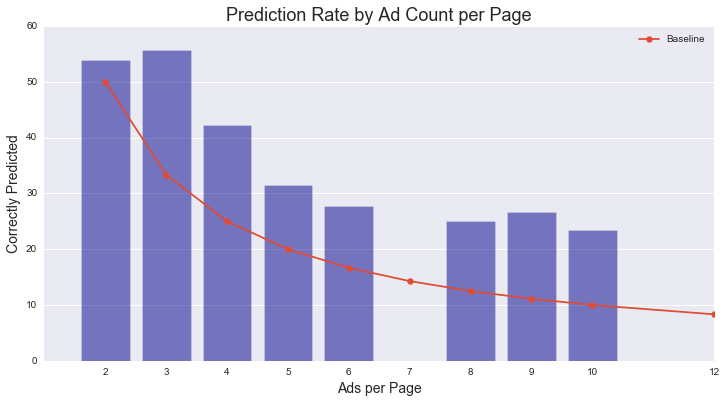

In [51]:
fig, ax1 = plt.subplots(figsize=(12,6))
base1 = [2,3,4,5,6,7,8,9,10,12]
base_line = [100./x for x in base1]

labels = ['2','3','4','5','6','7','8','9','10','12']
ax1.bar(per_page.index, 100*per_page['% Correct'], color='darkblue',
        alpha=0.5,align='center')
ax1.plot(per_page.index, base_line,marker ='H',label = 'Baseline')
ax1.set_title('Prediction Rate by Ad Count per Page', fontsize=18)
ax1.set_xlabel('Ads per Page', fontsize=14)
ax1.set_ylabel('Correctly Predicted', fontsize=14)
ax1.set_xlim([1,12])
ax1.set_xticks(per_page.index)
plt.grid(which = 'major',axis = 'x')
plt.legend(loc='best');

In [52]:

os.system('say "I am finished!"')
#os.system('say "All done, all done, all done!"')

0

In [53]:
features = pd.DataFrame(X_test.columns.T)

In [54]:
features['coef'] = abs(gbc.feature_importances_)

# note: use absolute value of coefficients to weight relative strenghts

In [55]:
features.columns = ['feature','coef']

In [56]:
features.head()

,feature,coef
0,platform_1,0.005956
1,platform_2,0.000928
2,state_AL,0.000646
3,state_AR,0.000216
4,state_AZ,0.001156


In [57]:
influencers = features.sort(columns= ['coef'], axis=0, ascending = False)

/Users/alex/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [60]:
influencers.head(10)

with open('./data/gbc_dtc.pkl', 'w') as picklefile:
    pickle.dump(influencers, picklefile)

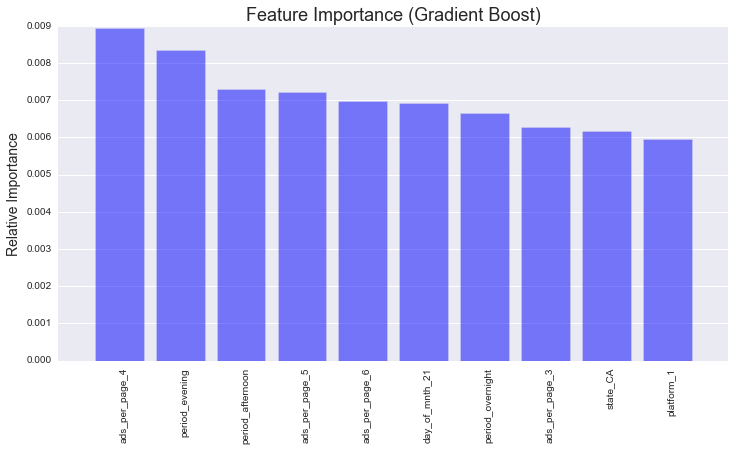

In [59]:
fig, ax1 = plt.subplots(figsize=(12,6))
labels = list(influencers.head(10)['feature'])
importance = list(influencers.head(10)['coef'])
ax1.bar(np.arange(0,10),importance, color='blue', alpha=0.5,align='center')
ax1.set_title('Feature Importance (Gradient Boost)', fontsize=18)
ax1.set_ylabel('Relative Importance', fontsize=14)
alex = ax1.set_xticklabels(labels, ha = 'left')
plt.setp(alex, rotation=90,fontsize=10)
ax1.set_xlim([-1,10])
plt.grid(which = 'major',axis = 'x')
ax1.set_xticks([0,1,2,3,4,5,6,7,8,9]);